In [1]:
from matplotlib import pyplot as plt
from numpy.polynomial.hermite import Hermite
from math import factorial
from qutip import *
import numpy as np
from scipy import *
import imageio
from tqdm import tqdm
import os
from os.path import exists



#constantes del sistema
hbar=1
m = 1.0
w = 1

#limites y numero de puntos de las representaciones graficas
limites=4
num_puntos=50
dx=2*limites/num_puntos
x = linspace(-limites,limites,num_puntos)
pi=3.141592

#numeros de polinomios de Hermite a considerar
N=7
offset=0

#ESPÍN
spin=0.5
dim_qm=int(2*spin+1)

nombre_archivo_descripcion_simulaciones=".\Simulaciones-Koopman\Descripcion_simulaciones_Hibrido.txt"
nombre_archivo_descripcion_graficas=".\Simulaciones-Koopman\Graficas\Descripcion_graficas_Hibrido.txt"

#OPERADORES IDENTIDAD
I_cl=qeye(N)
I_cl_total=tensor(qeye(N),qeye(N))
I_qm=qeye(dim_qm)
I=qeye(2*N*dim_qm)

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
C:\Users\usuario\AppData\Local\Temp/ipykernel_9776/2157183805.py:23: DeprecationWarning: scipy.linspace is deprecated and will be removed in SciPy 2.0.0, use numpy.linspace instead
  x = linspace(-limites,limites,num_puntos)


In [2]:
#DEFINICIÓN DE FUNCIONES

def agregar_linea_mas(nombre_archivo, texto):
    try:
        with open(nombre_archivo, 'a') as archivo:
            archivo.write('\n' + texto)
        print('Se ha agregado la línea exitosamente.')
    except Exception as e:
        print('Se produjo un error al agregar la línea:', str(e))
        
    
def numero_archivo(carpeta,nombre):
    N=0
    while exists(carpeta+nombre+"-"+str(N)+".png"):
        N+=1
    return N

def partial_quantum(rho,N_cl,N_quantum):
    A=rho.full()
    C=zeros((N_cl,N_cl),dtype=np.complex_)
        
    for i in range(N_cl):
        for j in range(N_cl):
            suma=0+0*1j
            for ii in range(N_quantum):
                suma+=A[N_quantum*i+ii][N_quantum*j+ii]
            C[i][j]=suma
    return Qobj(C)

def plotHermite(N,offset,vec):
    xx=linspace(-limites,limites,num_puntos)
    h=[0]*offset
    h=h+vec
    n=offset
    for i in vec:
        if i==0:
            n+=1
        else:
            break
    print(n)
    c=(1/sqrt(2**(n)*factorial(n)))*pow(m*w/pi,0.25)
    print(c)
    #f= (1/sqrt(2**(n)*factorial(n)))*pow(m*w/pi,0.25)*exp(-0.5*m*w*x**2)*Hermite(h)
    plt.xlim([-limites,limites])
    plt.plot(xx,c*exp(-0.5*m*w*xx**2)*Hermite(h)(xx))
   
#Devuelve funciones propias del oscialdor armonico
#N:Numero de pol Hermite
#offset:orden del primer polinomio de Hermite
#n: orden de la funcion propia a devolver
#x: punto espacial donde evaluar
def hermite(N,offset,n,x):
    if offset==0:
        h=zeros(N)
        h[n]=1
    else:
        h=[0]*offset
        vec=zeros(N)
        vec[n]=1
        h=h+vec
    c=(1/sqrt(2**(n)*factorial(n)))*pow(m*w/pi,0.25)
    return c*exp(-0.5*m*w*x**2)*Hermite(h)(x)
def rho2bloch(ρ):
    sxM=ρ*sigmax()
    sx=sxM.tr()
    syM=ρ*sigmay()
    sy=syM.tr()
    szM=ρ*sigmaz()
    sz=szM.tr()
    return [sx, sy, sz]

def vectors2points(list):
    listx=[j[0] for j in list]
    listy=[j[1] for j in list]
    listz=[j[2] for j in list]
    return [listx, listy, listz]

In [3]:
#Operadores creación y destrucción clásicos
annihilation_cl = np.zeros((N,N))
creation_cl = np.zeros((N,N))
for i in range(N-1):
    annihilation_cl[i][i+1]=math.sqrt(i+offset+1)
    creation_cl[i+1][i]=math.sqrt(i+offset+1)
#Operadores creación y destrucción cuánticos
annihilation_qm = np.zeros((dim_qm,dim_qm))
creation_qm = np.zeros((dim_qm,dim_qm))
for i in range(dim_qm-1):
    annihilation_qm[i][i+1]=math.sqrt(i+offset+1)
    creation_qm[i+1][i]=math.sqrt(i+offset+1)
creation_qm

array([[0., 0.],
       [1., 0.]])

In [4]:
#Operadores cr/destr en QuTip clasicos
aa_cl=Qobj(creation_cl)
a_cl=Qobj(annihilation_cl)
#Operadores cr/destr en QuTip quantum
aa_qm=Qobj(creation_qm)
a_qm=Qobj(annihilation_qm)

q_cl=0.5*(a_cl+aa_cl)
piq_cl=-complex(0,1)*0.5*(aa_cl-a_cl)

In [5]:
#Operadores creación y destrucción para q y p
aaq_cl=tensor(aa_cl,I_cl)
aap_cl=tensor(I_cl,aa_cl)
aq_cl=tensor(a_cl,I_cl)
ap_cl=tensor(I_cl,a_cl)

q=0.5*(aq_cl+aaq_cl)
piq=-complex(0,1)*0.5*(aaq_cl-aq_cl)
p=0.5*(aq_cl+aaq_cl)
pip=-complex(0,1)*0.5*(aaq_cl-aq_cl)

In [6]:
#Momentos angulares cuánticos
J2_1=qdiags([spin*(spin+1)]*dim_qm,0)

mz=[]
for j in range(dim_qm):
    mz.append(-spin+j)

Jp_qm=zeros((dim_qm,dim_qm))
Jm_qm=zeros((dim_qm,dim_qm))
Jz_qm=zeros((dim_qm,dim_qm))

for k in range(dim_qm):
    if k!=dim_qm-1:
        Jm_qm[k][k+1]=np.sqrt(spin*(spin+1)-mz[k+1]*(mz[k+1]-1))
        Jp_qm[k+1][k]=np.sqrt(spin*(spin+1)-mz[k]*(mz[k]+1))
    Jz_qm[k][k]=mz[k]
Jp=Qobj(Jp_qm)
Jm=Qobj(Jm_qm)
Jz=Qobj(Jz_qm)


J2=tensor(J2_1,I_qm)+tensor(I_qm,J2_1)+2*tensor(Jz,Jz)+tensor(Jp,Jm)+tensor(Jm,Jp)
#J2=tensor(J2_1,I_qm)+tensor(I_qm,J2_1)
J2

C:\Users\usuario\AppData\Local\Temp/ipykernel_9776/521012432.py:8: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  Jp_qm=zeros((dim_qm,dim_qm))
C:\Users\usuario\AppData\Local\Temp/ipykernel_9776/521012432.py:9: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  Jm_qm=zeros((dim_qm,dim_qm))
C:\Users\usuario\AppData\Local\Temp/ipykernel_9776/521012432.py:10: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  Jz_qm=zeros((dim_qm,dim_qm))


Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[2. 0. 0. 0.]
 [0. 1. 1. 0.]
 [0. 1. 1. 0.]
 [0. 0. 0. 2.]]

In [7]:
#CONDICIONES INICIALES
n_q=0
n_p=1

#PARTE CLÁSICA
ϕ_cl=tensor(basis(N,n_q),basis(N,n_p))

#PARTE CUÁNTICA
#TRIPLETE
#ϕ_qm=tensor(basis(dim_qm,1),basis(dim_qm,0))+tensor(basis(dim_qm,0),basis(dim_qm,1))
#SINGLETE
#ϕ_qm=tensor(basis(dim_qm,1),basis(dim_qm,0))-tensor(basis(dim_qm,0),basis(dim_qm,1))
ϕ_qm=tensor(basis(dim_qm,1),basis(dim_qm,1))
#ϕ_qm=(tensor(basis(dim_qm,0),basis(dim_qm,0))+tensor(basis(dim_qm,1),basis(dim_qm,0))+tensor(basis(dim_qm,0),basis(dim_qm,1))+tensor(basis(dim_qm,1),basis(dim_qm,1))).unit()+tensor(basis(dim_qm,1),basis(dim_qm,1))

#TOTAL
ϕ=tensor(ϕ_cl,ϕ_qm)


ϕ=ϕ.unit()
ρ=ϕ*ϕ.dag()
ρ_clasico=ϕ_cl*ϕ_cl.dag()

C:\Users\usuario\AppData\Local\Temp/ipykernel_9776/680430750.py:4: DeprecationWarning: scipy.linspace is deprecated and will be removed in SciPy 2.0.0, use numpy.linspace instead
  x = linspace(-limites,limites,num_puntos)
C:\Users\usuario\AppData\Local\Temp/ipykernel_9776/680430750.py:5: DeprecationWarning: scipy.linspace is deprecated and will be removed in SciPy 2.0.0, use numpy.linspace instead
  y = linspace(-limites,limites,num_puntos)
C:\Users\usuario\AppData\Local\Temp/ipykernel_9776/3660440051.py:54: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  h=zeros(N)
C:\Users\usuario\AppData\Local\Temp/ipykernel_9776/3660440051.py:61: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  c=(1/sqrt(2**(n)*factorial(n)))*pow(m*w/pi,0.25)
C:\Users\usuario\AppData\Local\Temp/ipykernel_9776/3660440051.py:62: DeprecationWarning: scipy.exp is deprecated and will be remov

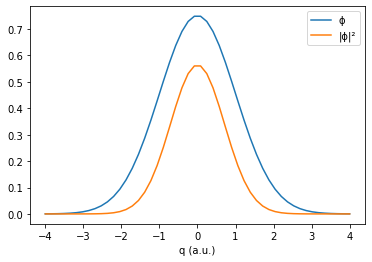

In [8]:
#REPRESENTACIÓN DE LA CONDICIÓN INICIAL DE LA DENSIDAD DE PROBABILIDAD DE LA POSICIÓN

fig, ax = plt.subplots()
x = linspace(-limites,limites,num_puntos)
y = linspace(-limites,limites,num_puntos)
# Crear la gráfica
ax.plot(x,hermite(N,offset,n_q,x),label="ϕ")
ax.plot(x,hermite(N,offset,n_q,x)*hermite(N,offset,n_q,x),label="|ϕ|²")

ax.set_xlabel('q (a.u.)')
ax.set_ylabel('')
#ax.set_title('Condición inicial q')

# Añadir leyenda
ax.legend(loc='upper right')
plt.savefig(f'./Simulaciones-Koopman/Graficas/Cond_inicial_q-n_q{n_q}.png',transparent = False, facecolor = 'white')
# Mostrar la gráfica
plt.show()

C:\Users\usuario\AppData\Local\Temp/ipykernel_9776/338720538.py:5: DeprecationWarning: scipy.linspace is deprecated and will be removed in SciPy 2.0.0, use numpy.linspace instead
  x = linspace(-limites,limites,num_puntos)
C:\Users\usuario\AppData\Local\Temp/ipykernel_9776/3660440051.py:54: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  h=zeros(N)
C:\Users\usuario\AppData\Local\Temp/ipykernel_9776/3660440051.py:61: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  c=(1/sqrt(2**(n)*factorial(n)))*pow(m*w/pi,0.25)
C:\Users\usuario\AppData\Local\Temp/ipykernel_9776/3660440051.py:62: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
  return c*exp(-0.5*m*w*x**2)*Hermite(h)(x)
C:\Users\usuario\AppData\Local\Temp/ipykernel_9776/3660440051.py:54: DeprecationWarning: scipy.zeros is deprecated and will be removed in 

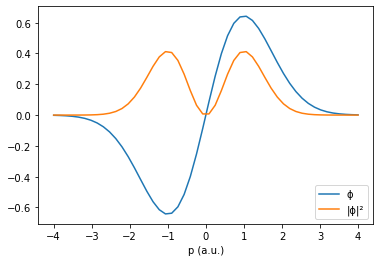

In [9]:
#REPRESENTACIÓN DE LA CONDICIÓN INICIAL DE LA DENSIDAD DE PROBABILIDAD DEL MOMENTO


fig, ax = plt.subplots()
x = linspace(-limites,limites,num_puntos)
# Crear la gráfica
ax.plot(y,hermite(N,offset,n_p,x),label="ϕ")
ax.plot(y,hermite(N,offset,n_p,x)*hermite(N,offset,n_p,x),label="|ϕ|²")

ax.set_xlabel('p (a.u.)')
ax.set_ylabel('')
#ax.set_title('Condición inicial p')

# Añadir leyenda
ax.legend(loc='lower right')
plt.savefig(f'./Simulaciones-Koopman/Graficas/Cond_inicial_p-n_p{n_p}.png',transparent = False, facecolor = 'white')
# Mostrar la gráfica
plt.show()

In [10]:
#T:Tiempo de simulacion (a.u.)
#alpha: constante de escalado en el Hamiltoniano
#pasos: numero de pasos de la simulación
T=10
α=1
pasos=40

In [11]:
descripcion="Simulacion hibrido, solo hamiltoniano clásico con dos operadores de krauss-corregido"

In [12]:
#HAMILTONIANO

Decaimiento=tensor(Qobj(np.array([[0,1],[0,0]])),Qobj(np.array([[0,1],[0,0]])))

#Hc=(1/(2*masa)*p*p+1j/2*masa*w*q*q)
#cte=0.16
Hc=α*(-complex(0,1)/(2*m)*(aap_cl+ap_cl)*(aaq_cl-aq_cl)+complex(0,1)/2*m*w*(aaq_cl+aq_cl)*(aap_cl-ap_cl))

#TÉRMINOS DE INTERACCIÓN
Hq=0*(tensor(sigmax(),I_qm)+tensor(I_qm,sigmax()))
#tensor(sigmax(),I_qm)+tensor(I_qm,sigmax())+
Hcq=0*(tensor((aaq_cl+aq_cl),tensor(sigmaz(),I_qm)+tensor(I_qm,sigmaz())))



#Operadores de Krauss
A0=tensor(6*q+piq-pip,J2)
A1=tensor(4*p-piq+pip,J2)

C0=A0
C1=1j*A1
C2=tensor(I_cl_total,Decaimiento)

#H=tensor(Hc,I_qm,I_qm)
H=tensor(Hc,I_qm,I_qm)+tensor(I_cl_total,Hq)+Hcq

In [13]:
ρ_trace=ρ.ptrace([0,1])

ρ_clasic=ϕ_cl*ϕ_cl.dag()


In [14]:
time=linspace(0,T,pasos)

#Evolución temporal del ESTADO DEL SISTEMA
ψ=[(-1j*Hc*t).expm()*ϕ_cl for t in time]
norma=[phi.norm() for phi in ψ]

C:\Users\usuario\AppData\Local\Temp/ipykernel_9776/525453594.py:1: DeprecationWarning: scipy.linspace is deprecated and will be removed in SciPy 2.0.0, use numpy.linspace instead
  time=linspace(0,T,pasos)


In [ ]:
#comutador=commutator(Hc,ρ)
rho=ρ.full()

rho2=(ρ*ρ).full()

#Simulación evolución de la matriz densidad dinámica Unitaria
result_total_sinKrauss=mesolve(H,ρ,time,progress_bar=True,options=Options(nsteps=500000))

#Simulación evolución de la matriz densidad dinámica Lindbladiana
#result_total=mesolve(H,ρ,time,c_ops=[C0,C1,C2],progress_bar=True,options=Options(nsteps=500000))

#Simulación evolución de la matriz densidad dinámica Lindbladiana con operador de Kraus puramente cuántico
result_total=mesolve(H,ρ,time,c_ops=[C0,C1],progress_bar=True,options=Options(nsteps=500000))

#Simulación evolución de la matriz densidad clásica
result_total_pureClassic=mesolve(Hc,ρ_clasico,time,progress_bar=True)



10.0%. Run time:   0.10s. Est. time left: 00:00:00:00
20.0%. Run time:   0.14s. Est. time left: 00:00:00:00
30.0%. Run time:   0.21s. Est. time left: 00:00:00:00
40.0%. Run time:   0.25s. Est. time left: 00:00:00:00
50.0%. Run time:   0.33s. Est. time left: 00:00:00:00
60.0%. Run time:   0.40s. Est. time left: 00:00:00:00
70.0%. Run time:   0.44s. Est. time left: 00:00:00:00
80.0%. Run time:   0.49s. Est. time left: 00:00:00:00
90.0%. Run time:   0.55s. Est. time left: 00:00:00:00
Total run time:   0.55s
10.0%. Run time:  14.10s. Est. time left: 00:00:02:06
20.0%. Run time:  27.98s. Est. time left: 00:00:01:51
30.0%. Run time:  41.92s. Est. time left: 00:00:01:37
40.0%. Run time:  55.77s. Est. time left: 00:00:01:23
50.0%. Run time:  71.37s. Est. time left: 00:00:01:11
60.0%. Run time:  86.81s. Est. time left: 00:00:00:57
70.0%. Run time: 103.92s. Est. time left: 00:00:00:44
80.0%. Run time: 117.91s. Est. time left: 00:00:00:29


In [ ]:
#Resultados para el sistema completo con el Operador de Krauss con Hamiltoniano clásico
result=[result_total.states[t] for t in range(len(time))]
rho_traza=[(result[i].ptrace([2,3])).tr() for i in range(len(result))]
#result_clasico=[partial_quantum(result[i],N**2,int(2*spin+1)**2) for i in range(len(result))]
result_clasico=[result[i].ptrace([0,1]) for i in range(len(result))]
result2_clasico=[result_clasico[i]*result_clasico[i] for i in range(len(result_clasico))]
result_quantum1=[result[i].ptrace([2]) for i in range(len(result))]
result_quantum2=[result[i].ptrace([3]) for i in range(len(result))]
result_quantum=[result[i].ptrace([2,3]) for i in range(len(result))]
result2_quantum1=[result_quantum1[i]*result_quantum1[i] for i in range(len(result))]
result2_quantum2=[result_quantum2[i]*result_quantum2[i] for i in range(len(result))]
result2_quantum=[result_quantum[i]*result_quantum[i] for i in range(len(result))]

#Resultados para el sistema completo sin operadores de Krauss con Hamiltoniano clásico
result_sinKrauss=[result_total_sinKrauss.states[t] for t in range(len(time))]
rho_traza2=[(result_sinKrauss[i].ptrace([2,3])).tr() for i in range(len(result))]
result_quantum1_sinKrauss=[result_sinKrauss[i].ptrace([2]) for i in range(len(result))]
result_quantum2_sinKrauss=[result_sinKrauss[i].ptrace([3]) for i in range(len(result))]
result_quantum_sinKrauss=[result_sinKrauss[i].ptrace([2,3]) for i in range(len(result))]
result_clasico_sinKrauss=[result_sinKrauss[i].ptrace([0,1]) for i in range(len(result))]
result2_quantum1_sinKrauss=[result_quantum1_sinKrauss[i]*result_quantum1_sinKrauss[i] for i in range(len(result))]
result2_quantum2_sinKrauss=[result_quantum2_sinKrauss[i]*result_quantum2_sinKrauss[i] for i in range(len(result))]
result2_quantum_sinKrauss=[result_quantum_sinKrauss[i]*result_quantum_sinKrauss[i] for i in range(len(result))]

#result_clasico_sinKrauss=[partial_quantum(result_sinKrauss[i],N**2,int(2*spin+1)**2) for i in range(len(result))]
result_clasico_sinKrauss=[result_sinKrauss[i].ptrace([0,1]) for i in range(len(result))]
result2_clasico_sinKrauss=[result_clasico_sinKrauss[i]*result_clasico_sinKrauss[i] for i in range(len(result))]


#Resultado para la parte clásica desacoplada
result_pureClassic=[result_total_pureClassic.states[t] for t in range(len(time))]
result2_pureClassic=[result_pureClassic[i]*result_pureClassic[i] for i in range(len(result))]

In [ ]:
#Pureza de la parte clásica del sistema completo con Hamiltoniano clásico con operadores de Krauss
rho2_traza=[(result[t]*result[t]).full().trace() for t in range(len(result))]
rho2_clasico_traza=[result2_clasico[t].full().trace() for t in range(len(result2_clasico))]
rho2_quantum_traza=[result2_quantum[t].full().trace() for t in range(len(result2_clasico))]

#Pureza de la parte clásica del sistema completo con Hamiltoniano clásico sin operadores de Krauss
rho_clasico_traza_sinKrauss=[result2_clasico_sinKrauss[t].full().trace() for t in range(len(result2_clasico_sinKrauss))]
rho2_clasico_traza_sinKrauss=[(result_sinKrauss[t]*result_sinKrauss[t]).full().trace() for t in range(len(result_sinKrauss))]
rho2_quantum_traza_sinKrauss=[result2_quantum_sinKrauss[t].full().trace() for t in range(len(result_sinKrauss))]
rho2_quantum1_traza_sinKrauss=[result2_quantum1_sinKrauss[t].full().trace() for t in range(len(result_sinKrauss))]
rho2_quantum2_traza_sinKrauss=[result2_quantum2_sinKrauss[t].full().trace() for t in range(len(result_sinKrauss))]


#Pureza de la parte clásica desacoplada
rho2_traza_pureClassic=[result2_pureClassic[t].full().trace() for t in range(len(time))]

In [ ]:
#Entropia de la parte clásica del sistema completo con operadores de Krauss
entropy_vn_classic_Krauss=[entropy_vn(rho, base=2.718281828459045, sparse=False) for rho in result_clasico]

#Entropía de a parte clásica del sistema completo sin operadores de Krauss
entropy_vn_classic_sinKrauss=[entropy_vn(rho, base=2.718281828459045, sparse=False) for rho in result_clasico_sinKrauss]

#Entropía total del sistema con operadores de Krauss
entropy_vn_Krauss=[entropy_vn(rho, base=2.718281828459045, sparse=False) for rho in result]

#Entropía total del sistema sin operadores de Krauss
entropy_vn_sinKrauss=[entropy_vn(rho, base=2.718281828459045, sparse=False) for rho in result_sinKrauss]


In [ ]:
#RESPRESENTACIÓN DE LA ENTROPÍA

fig, ax = plt.subplots()

# Crear la gráfica
ax.plot(time,entropy_vn_classic_Krauss,label="Lindblad")
ax.plot(time,entropy_vn_classic_sinKrauss,label="Unitaria")

ax.set_xlabel('Tiempo (a.u.)')
ax.set_ylabel('Entropía de Von Neumann')
ax.set_title('')

# Añadir leyenda
ax.legend(loc='center right')
numero_file=numero_archivo("./Simulaciones-Koopman/Graficas/",f'Entropía-comparativa-N_{N}-T_{T}-P_{pasos}-alpha_{α}-version')
nombre_grafica=f'Entropía-comparativa-N_{N}-T_{T}-P_{pasos}-alpha_{α}-version-{numero_file}.png'
plt.savefig("./Simulaciones-Koopman/Graficas/"+nombre_grafica,transparent = False, facecolor = 'white')
# Mostrar la gráfica
plt.show()


descripcion_grafica="Comparativa de entropía entre la dinámica unitaria y la limbladiana para un Hamiltoniano puramente clásico"
print(numero_file)
agregar_linea_mas(nombre_archivo_descripcion_graficas,nombre_grafica+"---------"+descripcion_grafica)


In [ ]:
#RESPRESENTACIÓN DE LA TRAZA CLÁSICA

fig, ax = plt.subplots()

# Crear la gráfica
ax.plot(time,rho2_quantum_traza,label="Lindblad")
ax.plot(time,rho2_quantum_traza_sinKrauss,label="Unitaria")

ax.set_xlabel('Tiempo (a.u.)')
ax.set_ylabel('Traza(ρ^2)')
ax.set_title('Pureza parte cuántica')

# Añadir leyenda
ax.legend(loc='center right')
numero_file=numero_archivo("./Simulaciones-Koopman/Graficas/",f'Pureza-comparativa-N_{N}-T_{T}-P_{pasos}-alpha_{α}-version')
nombre_grafica=f'Pureza-QUANTUM-comparativa-N_{N}-T_{T}-P_{pasos}-alpha_{α}-version-{numero_file}.png'
plt.savefig("./Simulaciones-Koopman/Graficas/"+nombre_grafica,transparent = False, facecolor = 'white')
# Mostrar la gráfica
plt.show()


descripcion_grafica="Comparativa de pureza entre la dinámica unitaria y la limbladiana para un Hamiltoniano puramente clásico"
print(numero_file)
agregar_linea_mas(nombre_archivo_descripcion_graficas,nombre_grafica+"---------"+descripcion_grafica)


In [ ]:
#RESPRESENTACIÓN DE LA TRAZA CUÁNTICA


fig, ax = plt.subplots()

# Crear la gráfica
ax.plot(time,rho2_clasico_traza,label="Lindblad")
#ax.plot(time,rho2_clasico_traza_sinKrauss,label="Unitaria")

ax.set_xlabel('Tiempo (a.u.)')
ax.set_ylabel('Traza(ρ^2)')
ax.set_title('Pureza parte clásica')

# Añadir leyenda
ax.legend(loc='center right')
numero_file=numero_archivo("./Simulaciones-Koopman/Graficas/",f'Pureza-comparativa-N_{N}-T_{T}-P_{pasos}-alpha_{α}-version')
nombre_grafica=f'Pureza-CLASSIC-limites-comparativa-N_{N}-T_{T}-P_{pasos}-alpha_{α}-version-{numero_file}.png'
plt.savefig("./Simulaciones-Koopman/Graficas/"+nombre_grafica,transparent = False, facecolor = 'white')
# Mostrar la gráfica
ax.set_ylim(0,1.1)
plt.show()


descripcion_grafica="Comparativa de pureza entre la dinámica unitaria y la limbladiana para un Hamiltoniano puramente clásico"
print(numero_file)
agregar_linea_mas(nombre_archivo_descripcion_graficas,nombre_grafica+"---------"+descripcion_grafica)

In [ ]:
# Representation of the Bloch sphere
b1=Bloch()
b2=Bloch()

# We can also add points on the sphere


#b1.add_points(vectors2points([rho2bloch(j) for j in result_quantum1]))
#b2.add_points(vectors2points([rho2bloch(j) for j in result_quantum2]))
b1.add_points(vectors2points([rho2bloch(j) for j in result_quantum1]))
b1.add_points(vectors2points([rho2bloch(j) for j in result_quantum1_sinKrauss]))
b2.add_points(vectors2points([rho2bloch(j) for j in result_quantum2]))
#b2.add_points(vectors2points([rho2bloch(j) for j in result_quantum2_sinKrauss]))

#b.add_points(vectors2points(([rho2bloch(j) for j in ρt])))

# Show plot
b1.show()
b2.show()
b1.save(dirc='./Simulaciones-Koopman/Bloch')


In [ ]:
# Representation of the Bloch sphere
b1=Bloch()
b2=Bloch()

# We can also add points on the sphere


b1.add_points(vectors2points([rho2bloch(j) for j in result_quantum1_sinKrauss]))
b2.add_points(vectors2points([rho2bloch(j) for j in result_quantum2_sinKrauss]))

#b.add_points(vectors2points(([rho2bloch(j) for j in ρt])))

# Show plot
b1.show()
b2.show()
b1.save(dirc='./Simulaciones-Koopman/Bloch')

In [ ]:
# Representation of the Bloch sphere
bb1=Bloch()
bb2=Bloch()

# We can also add points on the sphere


bb1.add_points(vectors2points([rho2bloch(result_quantum1[0])]))
bb2.add_points(vectors2points([rho2bloch(result_quantum2[0])]))

#b.add_points(vectors2points(([rho2bloch(j) for j in ρt])))

# Show plot
bb1.show()
bb2.show()

In [ ]:
#Evolucion del estado DINÁMICA LINDBLADIANA REPRESENTACION GRAFICA

estadosRho=[]

numero=0
string="Oscilador"
while os.path.exists(f'./Simulaciones-Koopman/{string}-{numero}-N_{N}-T_{T}-P_{pasos}-alpha_{α}.gif'):
    numero+=1
contador=0
for t in tqdm(range(0,pasos,1)):# Creamos la figura y el objeto Axes3D
    x = linspace(-limites,limites,num_puntos)
    y = linspace(-limites,limites,num_puntos)
    x, y = np.meshgrid(x, y)
    
    z=zeros((num_puntos,num_puntos))
    #estado=zeros((num_puntos,num_puntos))
    estado=0
    
    
    for i in range(N):
        for j in range(N):
            for ii in range(N):
                for jj in range(N):
                    estado+=result_clasico[contador].full()[N*i+j][N*ii+jj]*hermite(N,offset,i,x)*hermite(N,offset,j,y)*hermite(N,offset,ii,x)*hermite(N,offset,jj,y)
                    #estado[i][j]+= result.states[t].full()[N*ii+jj][N*ii+jj]*hermite(N,offset,ii,x[i])*hermite(N,offset,jj,y[j])*hermite(N,offset,ii,x[i])*hermite(N,offset,jj,y[j])
                    #print(hermite(N,offset,ii,x[i])*hermite(N,offset,jj,y[j])*hermite(N,offset,ii,x[i])*hermite(N,offset,jj,y[j]))
    rho=zeros((num_puntos,num_puntos))
    for X in range(num_puntos):
        for Y in range(num_puntos):
            rho[X][Y]=estado[X][Y]
    z=rho
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    # Creamos la superficie
    surf = ax.plot_surface(x, y, rho, cmap='viridis')
    #surf = ax.plot_surface(x, y, z, cmap='jet')
    # Añadimos los ejes y los títulos
    ax.set_xlabel('q (a.u.)', fontsize=22)
    ax.set_ylabel('p (a.u.)', fontsize=22)
    ax.set_zlabel('ρ', fontsize=18)
    ax.set_title('')
    ax.set_zlim(-1,1)
    
    # Ajustamos la perspectiva y la vista
    ax.view_init(30, 60)
    plt.savefig(f'./Simulaciones-Koopman/Imagenes/img_LINDBLAD-{numero}-N_{N}-T_{T}-P_{pasos}-alpha_{α}-{t}.png',transparent = False, facecolor = 'white')
    #plt.show()
    contador+=1
# Mostramos el gráfico

In [ ]:
#CREAR GIF
frames = []
nombre=f'{string}-Hibrido-{numero}-N_{N}-T_{T}-P_{pasos}-alpha_{α}.gif'
nombre_largo="./Simulaciones-Koopman/"+nombre
for t in range(0,pasos,3):
    image = imageio.v2.imread(f'./Simulaciones-Koopman/Imagenes/img_RHO-{numero}-N_{N}-T_{T}-P_{pasos}-alpha_{α}-{t}.svg')
    frames.append(image)
imageio.mimsave(nombre_largo,frames,fps = 5)
agregar_linea_mas(nombre_archivo_descripcion_simulaciones,nombre+"---------"+descripcion)

In [ ]:
#Evolucion del estado DIÁMICA UNITARIA REPRESENTACION GRAFICA

estadosRho=[]

numero=0
string="Oscilador"
while os.path.exists(f'./Simulaciones-Koopman/{string}-{numero}-N_{N}-T_{T}-P_{pasos}-alpha_{α}.gif'):
    numero+=1
contador=0
for t in tqdm(range(0,pasos,1)):# Creamos la figura y el objeto Axes3D
    x = linspace(-limites,limites,num_puntos)
    y = linspace(-limites,limites,num_puntos)
    x, y = np.meshgrid(x, y)
    
    z=zeros((num_puntos,num_puntos))
    #estado=zeros((num_puntos,num_puntos))
    estado=0
    
    
    for i in range(N):
        for j in range(N):
            for ii in range(N):
                for jj in range(N):
                    estado+=result_clasico_sinKrauss[contador].full()[N*i+j][N*ii+jj]*hermite(N,offset,i,x)*hermite(N,offset,j,y)*hermite(N,offset,ii,x)*hermite(N,offset,jj,y)
                    #estado[i][j]+= result.states[t].full()[N*ii+jj][N*ii+jj]*hermite(N,offset,ii,x[i])*hermite(N,offset,jj,y[j])*hermite(N,offset,ii,x[i])*hermite(N,offset,jj,y[j])
                    #print(hermite(N,offset,ii,x[i])*hermite(N,offset,jj,y[j])*hermite(N,offset,ii,x[i])*hermite(N,offset,jj,y[j]))
    rho=zeros((num_puntos,num_puntos))
    for X in range(num_puntos):
        for Y in range(num_puntos):
            rho[X][Y]=estado[X][Y]
    z=rho
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    # Creamos la superficie
    surf = ax.plot_surface(x, y, rho, cmap='viridis')
    #surf = ax.plot_surface(x, y, z, cmap='jet')
    # Añadimos los ejes y los títulos
    ax.set_xlabel('q (a.u.)', fontsize=22)
    ax.set_ylabel('p (a.u.)', fontsize=22)
    ax.set_zlabel('ρ', fontsize=18)
    ax.set_title('')
    ax.set_zlim(-1,1)
    
    # Ajustamos la perspectiva y la vista
    ax.view_init(30, 60)
    plt.savefig(f'./Simulaciones-Koopman/Imagenes/img_UNITARIA-{numero}-N_{N}-T_{T}-P_{pasos}-alpha_{α}-{t}.png',transparent = False, facecolor = 'white')
    #plt.show()
    contador+=1
# Mostramos el gráfico

In [ ]:
#CREAR GIF
frames = []
nombre=f'{string}-Hibrido-{numero}-N_{N}-T_{T}-P_{pasos}-alpha_{α}.gif'
nombre_largo="./Simulaciones-Koopman/"+nombre
for t in range(0,pasos,4):
    image = imageio.v2.imread(f'./Simulaciones-Koopman/Imagenes/img_UNITARIA-{numero}-N_{N}-T_{T}-P_{pasos}-alpha_{α}-{t}.png')
    frames.append(image)
imageio.mimsave(nombre_largo,frames,fps = 5)
agregar_linea_mas(nombre_archivo_descripcion_simulaciones,nombre+"---------"+descripcion)

In [ ]:
#REPRESENTACIÓN ESTADO INICIAL ROTANDO

x = linspace(-limites,limites,num_puntos)
y = linspace(-limites,limites,num_puntos)
x, y = np.meshgrid(x, y)

z=zeros((num_puntos,num_puntos))
#estado=zeros((num_puntos,num_puntos))
estado=0


for i in range(N):
    for j in range(N):
        for ii in range(N):
            for jj in range(N):
                estado+=result_clasico[0].full()[N*i+j][N*ii+jj]*hermite(N,offset,i,x)*hermite(N,offset,j,y)*hermite(N,offset,ii,x)*hermite(N,offset,jj,y)
                #estado[i][j]+= result.states[t].full()[N*ii+jj][N*ii+jj]*hermite(N,offset,ii,x[i])*hermite(N,offset,jj,y[j])*hermite(N,offset,ii,x[i])*hermite(N,offset,jj,y[j])
                #print(hermite(N,offset,ii,x[i])*hermite(N,offset,jj,y[j])*hermite(N,offset,ii,x[i])*hermite(N,offset,jj,y[j]))
rho=zeros((num_puntos,num_puntos))
for X in range(num_puntos):
    for Y in range(num_puntos):
        rho[X][Y]=estado[X][Y]
z=rho
ang_ini=60
ang_fin=420
ang_paso=2
for angulo in tqdm(range(ang_ini,ang_fin,ang_paso)):

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    # Creamos la superficie
    surf = ax.plot_surface(x, y, rho, cmap='viridis')
    #surf = ax.plot_surface(x, y, z, cmap='jet')
    # Añadimos los ejes y los títulos
    ax.set_xlabel('q (a.u.)', fontsize=22)
    ax.set_ylabel('p (a.u.)', fontsize=22)
    ax.set_zlabel('ρ', fontsize=18)
    ax.set_title('Superficie 3D')
    ax.set_zlim(-1,1)

    # Ajustamos la perspectiva y la vista
    ax.view_init(30, angulo/2)
    plt.savefig(f'./Simulaciones-Koopman_MoverAngulo/Imagenes/img-{angulo}.png',transparent = False, facecolor = 'white')


In [ ]:
#CREAR GIF
frames = []
for angulo in tqdm(range(ang_ini,ang_fin,ang_paso)):
    nombre=f'./Simulaciones-Koopman_MoverAngulo/img-{numero}.gif'
    image = imageio.v2.imread(f'./Simulaciones-Koopman_MoverAngulo/Imagenes/img-{angulo}.png')
    frames.append(image)
imageio.mimsave(nombre,frames,fps = 5)